## Notebook Magic

In [1]:
%matplotlib inline
%load_ext autoreload

## Imports

In [2]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve

from sklearn.linear_model import LogisticRegression, Lasso

In [3]:
df = pd.read_parquet("s3://iefp-unemployment/intermediate/transform/intermediate.parquet")
df.shape

(145458, 94)

In [4]:
# Drop rows with nan demographics (fix bug!)
df = df[df.age.notna()]

In [5]:
df.success.value_counts() / len(df)

True     0.529509
False    0.470491
Name: success, dtype: float64

## Construct modelling table

In [6]:
interv_cols = [col for col in df.columns if "intervention" in col]
X = df[interv_cols].copy()

# Strip col names
X.columns = [col.replace("intervention_date_", "") for col in X.columns]

# Make df boolean
X = (X.notna()).astype('int')

# Filter for frequent interventions
frequent_i = X.mean()[X.mean() > 0.01].index.tolist()
X = X[frequent_i]

In [7]:
dems = ["age", "gender", "civil_status", "rsi", "desired_work_time", "desired_contract"]
X[dems] = df[dems]
X["register_month"] = df.register_date.dt.month
X["register_year"] = df.register_date.dt.year
X = pd.get_dummies(X, drop_first=True, dummy_na=True)
X.head()

,208,225,226,319,416,427,506,507,611,7005,...,civil_status_U,civil_status_V,civil_status_nan,rsi_True,rsi_nan,desired_work_time_P,desired_work_time_nan,desired_contract_P,desired_contract_T,desired_contract_nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [22]:
# Set output variable
Y = df["ttj_sub_9"]
Y.value_counts() / len(Y)

False    0.816624
True     0.183376
Name: ttj_sub_9, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [10]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [11]:
confusion_matrix(y_test, rf.predict(X_test))

array([[25705, 21299],
       [ 1741,  8777]])

In [12]:
accuracy_score(y_test, rf.predict(X_test))

0.5994575988317513

0.31000589014872626 Precision at 0.8 Recall


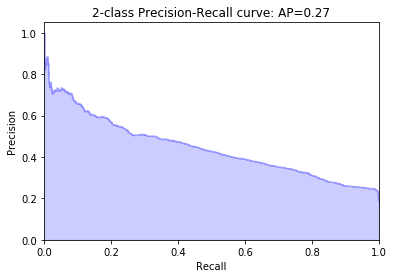

In [13]:
def plot_precision_recall(y_test, y_pred, y_prob):
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    print("{} Precision at {} Recall".format(precision[recall>0.8].max(), 0.8))

    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
plot_precision_recall(y_test, y_pred, y_prob)

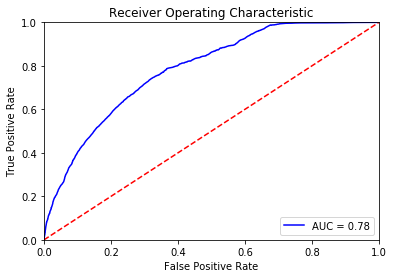

In [14]:
fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [15]:
pd.Series(rf.feature_importances_, X_train.columns).sort_values(ascending=False).head(20)

427               0.216944
register_year     0.197632
416               0.138052
age               0.128603
civil_status_S    0.065556
register_month    0.060434
319               0.041456
208               0.035321
772               0.030395
rsi_True          0.017557
785               0.012399
226               0.010734
7017              0.009441
796               0.008706
7005              0.007028
506               0.006263
611               0.004538
507               0.002348
777               0.001731
civil_status_U    0.001244
dtype: float64

In [16]:
lg = Lasso(alpha=0.1)
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
y_prob = lg.predict_proba(X_test)[:,1]

/home/tobi_richter/iefp/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [17]:
confusion_matrix(y_test, rf.predict(X_test))

array([[25705, 21299],
       [ 1741,  8777]])

In [18]:
accuracy_score(y_test, rf.predict(X_test))

0.5994575988317513

0.28241175681116626 Precision at 0.8 Recall


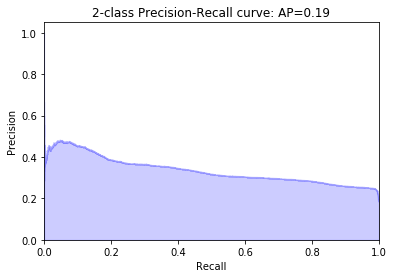

In [19]:
plot_precision_recall(y_test, y_pred, y_prob)

In [20]:
feats = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(lg.coef_))], axis = 1)
feats.columns = ["Feature", "Coefficient"]
feats.sort_values("Coefficient", ascending=False)

,Feature,Coefficient
3,319,0.809726
10,7017,0.531020
2,226,0.503192
14,796,0.494997
9,7005,0.491900
0,208,0.288396
6,506,0.271207
15,9902,0.260571
25,civil_status_U,0.071592
32,desired_contract_P,0.051084


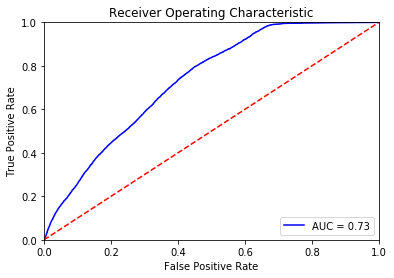

In [21]:
fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()